# ANALYSING CIC 2017 DATASET AND SELECTING BEST FEATURES FOR SLOWLORIS ATTACK


## Index
    1. Data Preparation
    2. Data Split
    3. Feature Selection
    4. PCA
    5. Testing

In [78]:
from __future__ import print_function

import os
import subprocess
import seaborn as sns  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2

In [79]:
def get_data():
    if os.path.exists("slow_loris_filtered.csv"):
        print("-- slow_loris.csv found locally")
    df = pd.read_csv("slow_loris_filtered.csv", index_col=False)
    return df

In [80]:
def encode_target(df, target_column):
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    map_to_int = {name: n for n, name in enumerate(targets)}
    df_mod["Target"] = df_mod[target_column].replace(map_to_int)
    return (df_mod, targets)

In [81]:
data = get_data()

-- slow_loris.csv found locally


In [82]:
print("* label types:", data[" Label"].unique(), sep="\n")

print(data.keys())
print(data.shape[0])
print(data.shape[1])

* label types:
['BENIGN' 'DoS slowloris']
Index([u'Flow ID', u' Source IP', u' Source Port', u' Destination IP',
       u' Destination Port', u' Protocol', u' Timestamp', u' Flow Duration',
       u' Total Fwd Packets', u' Total Backward Packets',
       u'Total Length of Fwd Packets', u' Total Length of Bwd Packets',
       u' Fwd Packet Length Max', u' Fwd Packet Length Min',
       u' Fwd Packet Length Mean', u' Fwd Packet Length Std',
       u'Bwd Packet Length Max', u' Bwd Packet Length Min',
       u' Bwd Packet Length Mean', u' Bwd Packet Length Std', u'Flow Bytes/s',
       u' Flow Packets/s', u' Flow IAT Mean', u' Flow IAT Std',
       u' Flow IAT Max', u' Flow IAT Min', u'Fwd IAT Total', u' Fwd IAT Mean',
       u' Fwd IAT Std', u' Fwd IAT Max', u' Fwd IAT Min', u'Bwd IAT Total',
       u' Bwd IAT Mean', u' Bwd IAT Std', u' Bwd IAT Max', u' Bwd IAT Min',
       u'Fwd PSH Flags', u' Bwd PSH Flags', u' Fwd URG Flags',
       u' Bwd URG Flags', u' Fwd Header Length', u' Bwd Head

# 1.0 We process data first

### We initially drop variables that won't contribute to knowlege of slowloris attack because they change from instance to instance

In [83]:
columns = ['Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp',]
data.drop(columns, inplace=True, axis=1)
print(data.keys())
print(data.shape[0])
print(data.shape[1])

Index([u' Flow Duration', u' Total Fwd Packets', u' Total Backward Packets',
       u'Total Length of Fwd Packets', u' Total Length of Bwd Packets',
       u' Fwd Packet Length Max', u' Fwd Packet Length Min',
       u' Fwd Packet Length Mean', u' Fwd Packet Length Std',
       u'Bwd Packet Length Max', u' Bwd Packet Length Min',
       u' Bwd Packet Length Mean', u' Bwd Packet Length Std', u'Flow Bytes/s',
       u' Flow Packets/s', u' Flow IAT Mean', u' Flow IAT Std',
       u' Flow IAT Max', u' Flow IAT Min', u'Fwd IAT Total', u' Fwd IAT Mean',
       u' Fwd IAT Std', u' Fwd IAT Max', u' Fwd IAT Min', u'Bwd IAT Total',
       u' Bwd IAT Mean', u' Bwd IAT Std', u' Bwd IAT Max', u' Bwd IAT Min',
       u'Fwd PSH Flags', u' Bwd PSH Flags', u' Fwd URG Flags',
       u' Bwd URG Flags', u' Fwd Header Length', u' Bwd Header Length',
       u'Fwd Packets/s', u' Bwd Packets/s', u' Min Packet Length',
       u' Max Packet Length', u' Packet Length Mean', u' Packet Length Std',
       u' Packe

### We also need to convert lables into numeric values for classification

In [84]:
df2, targets = encode_target(data, " Label")



### We drop any rows that contain NaN

In [85]:
df2 = df2.dropna(axis=0, how='any')
df2.isnull().sum().sum()

0

### We also drop columns that have 0 variance

In [86]:
list_unq = (df2.apply(pd.Series.nunique) != 1)
list_unq[list_unq == 0]

 Bwd PSH Flags           False
 Fwd URG Flags           False
 Bwd URG Flags           False
 CWE Flag Count          False
Fwd Avg Bytes/Bulk       False
 Fwd Avg Packets/Bulk    False
 Fwd Avg Bulk Rate       False
 Bwd Avg Bytes/Bulk      False
 Bwd Avg Packets/Bulk    False
Bwd Avg Bulk Rate        False
dtype: bool

In [87]:
df2 = df2.loc[:, df2.apply(pd.Series.nunique) != 1]

# 2.0 Data split
## We split data in features, lables

In [88]:
features = list(df2.columns[:-2])
y = df2["Target"]
X = df2[features]
print("* features:", features, sep="\n")

* features:
[' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count', ' ECE Flag Count', ' Down/Up Ratio', ' Average Packet S

In [89]:
X

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,1137846,10,10,851,3950,267,0,85.100000,99.870416,1953,...,5,32,0.0,0.00000,0.0,0.0,0.000,0.00000,0.0,0.0
1,512617,6,7,468,635,282,0,78.000000,122.846245,458,...,3,32,0.0,0.00000,0.0,0.0,0.000,0.00000,0.0,0.0
2,1266840,4,3,1095,2929,1095,0,273.750000,547.500000,1481,...,1,32,0.0,0.00000,0.0,0.0,0.000,0.00000,0.0,0.0
3,99,2,0,0,0,0,0,0.000000,0.000000,0,...,0,32,0.0,0.00000,0.0,0.0,0.000,0.00000,0.0,0.0
4,307666,7,6,451,5174,451,0,64.428571,170.461977,1448,...,1,32,0.0,0.00000,0.0,0.0,0.000,0.00000,0.0,0.0
5,183932,10,7,1599,6661,1599,0,159.900000,505.648198,1884,...,1,32,0.0,0.00000,0.0,0.0,0.000,0.00000,0.0,0.0
6,3,2,0,2791,0,1753,1038,1395.500000,505.581349,0,...,1,32,0.0,0.00000,0.0,0.0,0.000,0.00000,0.0,0.0
7,98,2,0,0,0,0,0,0.000000,0.000000,0,...,0,32,0.0,0.00000,0.0,0.0,0.000,0.00000,0.0,0.0
8,5715038,4,2,0,0,0,0,0.000000,0.000000,0,...,0,32,0.0,0.00000,0.0,0.0,0.000,0.00000,0.0,0.0
9,5585147,3,1,0,0,0,0,0.000000,0.000000,0,...,0,32,0.0,0.00000,0.0,0.0,0.000,0.00000,0.0,0.0


0    25466
1     5788
Name: Target, dtype: int64

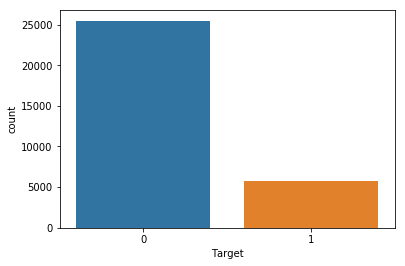

In [90]:
graph = sns.countplot(y ,label="Count")
df2["Target"].value_counts()

### Heat map

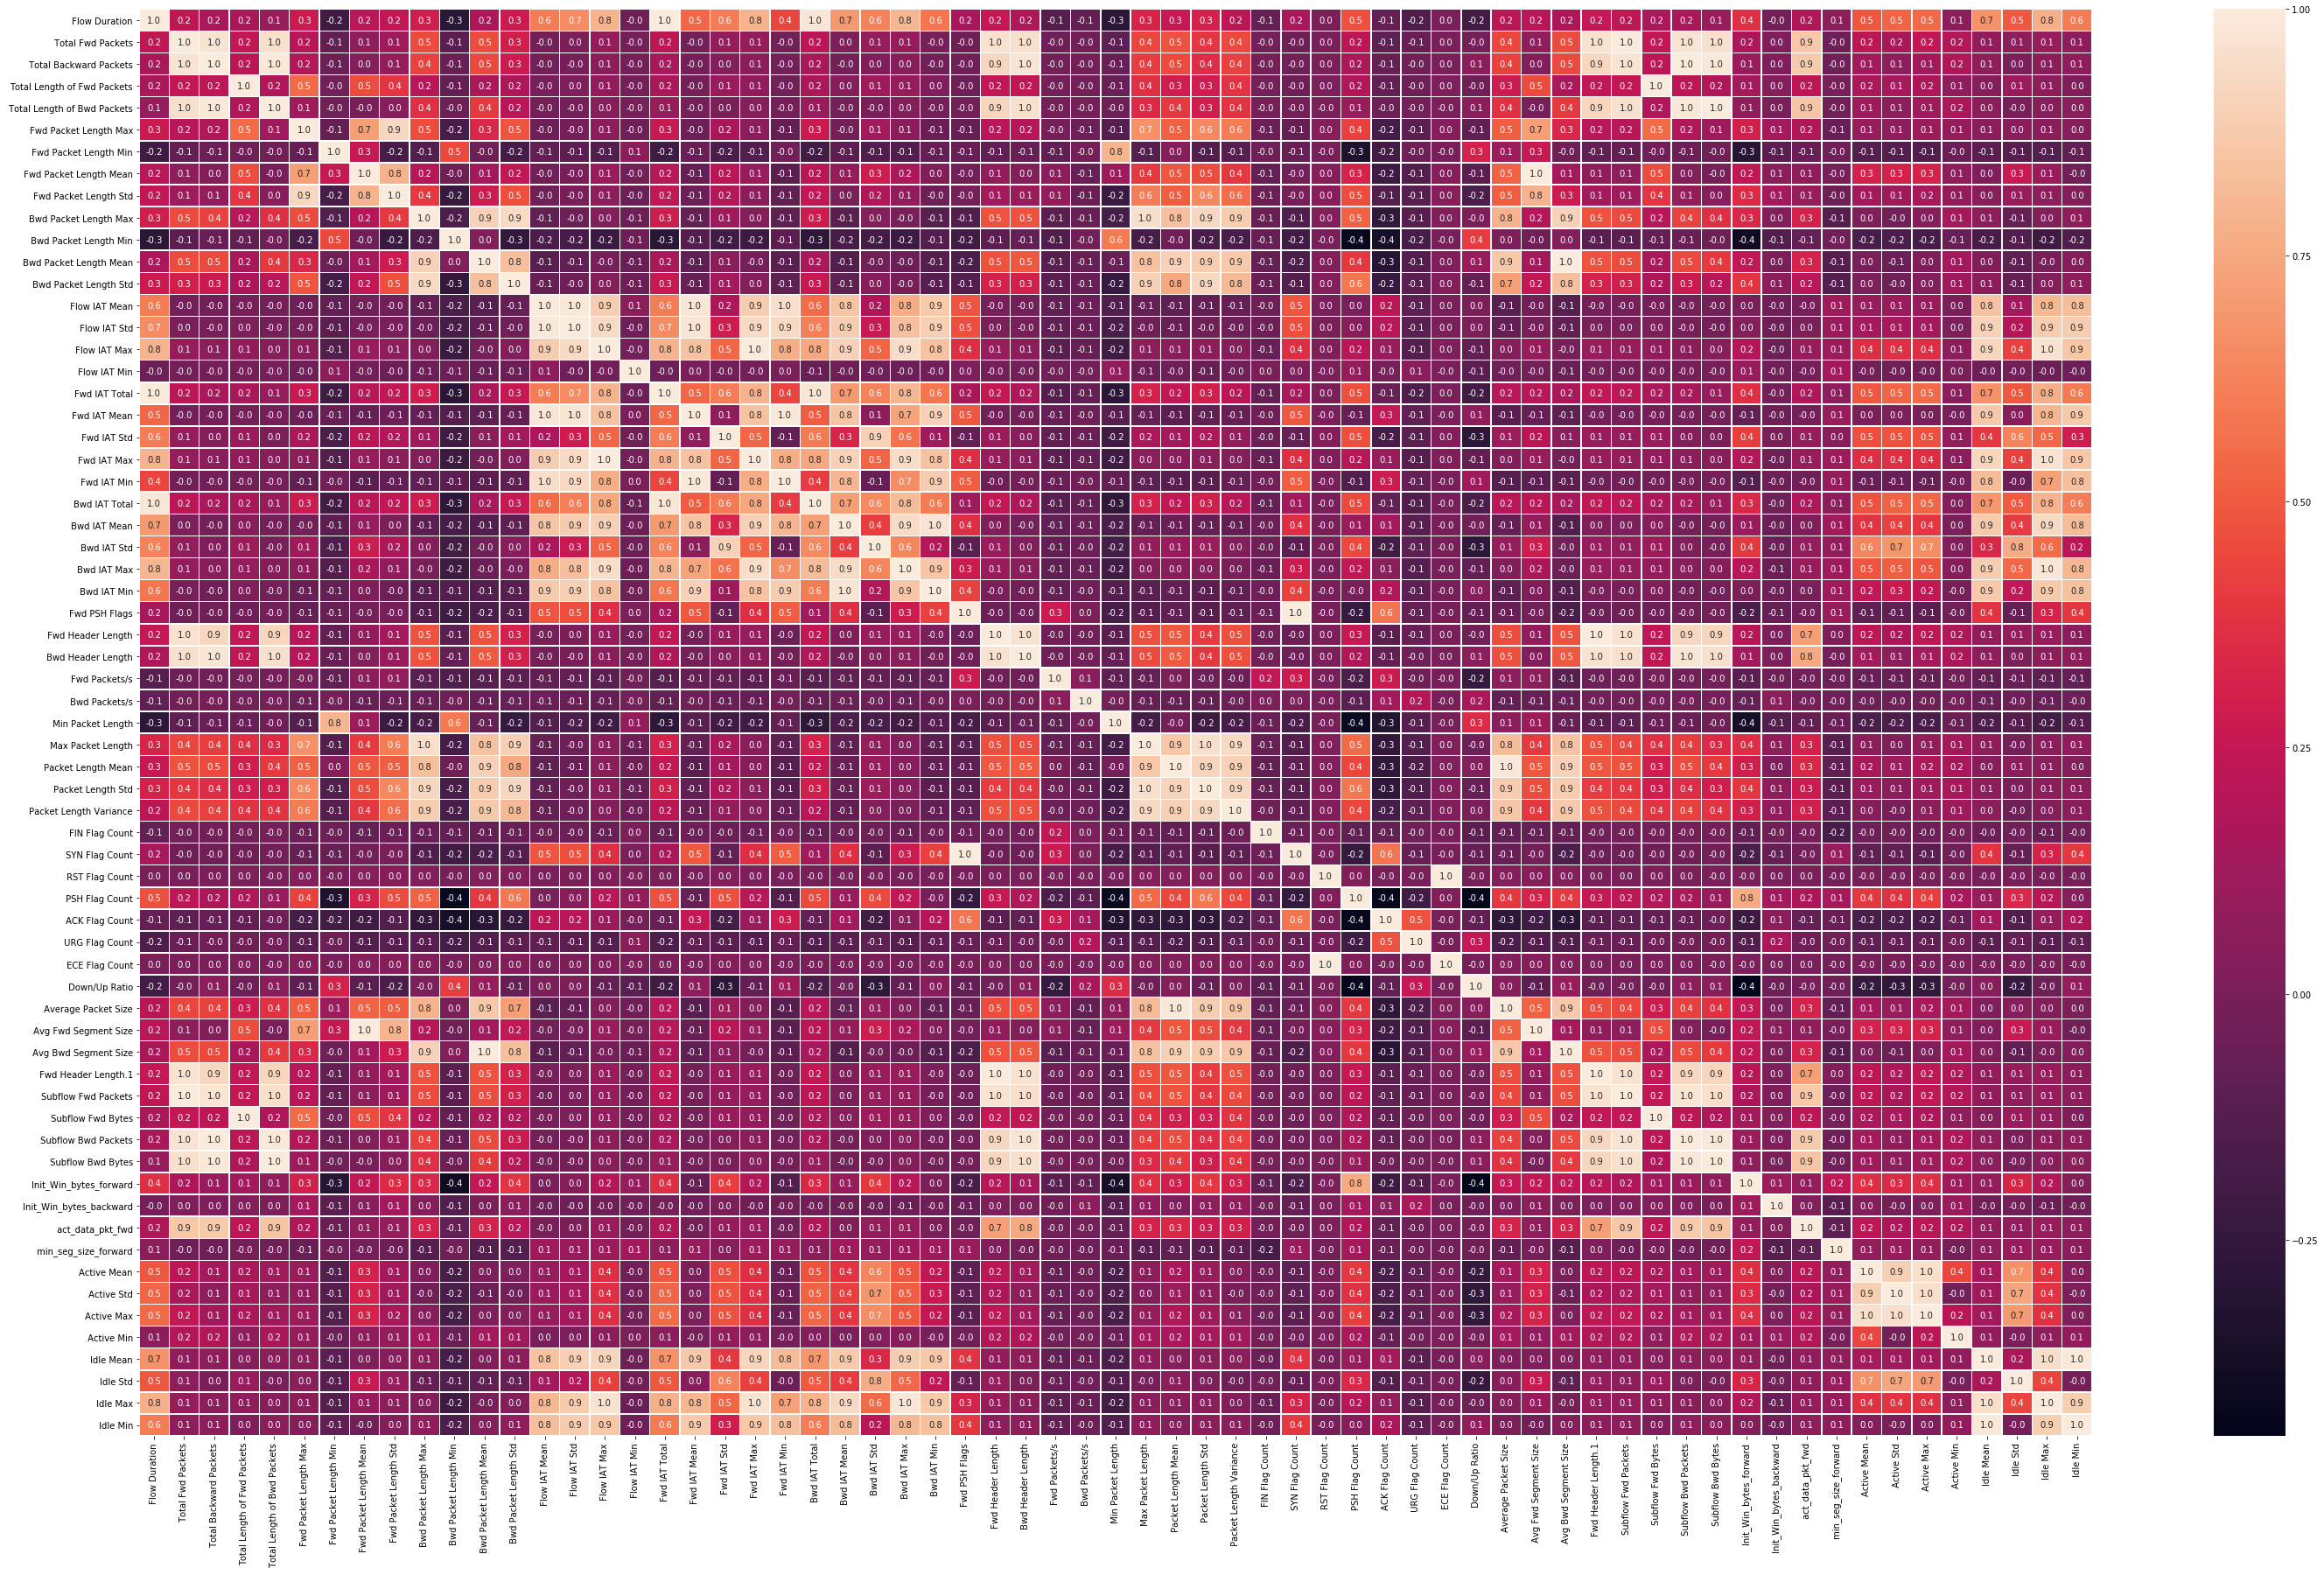

In [91]:
f, ax = plt.subplots(figsize=(50, 30))
sns_plot = sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax)

In [92]:
sns_plot.figure.savefig("output_50_30.png")

### df2 is original data frame with neccesary processing done. From now on we make variants of data frame X and Y








# 3.0 Feature Selection


### Index
     3.1 High Correlation
     3.2 K best features
     3.3 Recursive feature elimination with random forest
     3.4 Low Variance
     3.5 Recursice feature elimination with cross validation and random forest
     3.6 Tree based feature selection

## 3.1 High Correlation [Here 95%  and above]



In [93]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [94]:
upper

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Flow Duration,NaN,0.230412,0.158531,0.164972,0.101541,0.273838,0.207387,0.209277,0.247046,0.292937,...,0.177563,0.065692,0.489157,0.526094,0.546194,0.059080,0.677048,0.491315,0.775793,0.598569
Total Fwd Packets,NaN,NaN,0.971025,0.243083,0.958453,0.207622,0.077226,0.069005,0.125934,0.455142,...,0.861757,0.037273,0.225308,0.167509,0.237077,0.185597,0.079972,0.069070,0.094757,0.067640
Total Backward Packets,NaN,NaN,NaN,0.228534,0.985396,0.187749,0.050730,0.027925,0.093306,0.431763,...,0.871536,0.041462,0.138709,0.075337,0.138812,0.178781,0.068104,0.002345,0.059938,0.067392
Total Length of Fwd Packets,NaN,NaN,NaN,NaN,0.174373,0.548558,0.030295,0.459018,0.386934,0.207482,...,0.227186,0.010736,0.158149,0.146252,0.171672,0.072040,0.039581,0.110637,0.074325,0.020309
Total Length of Bwd Packets,NaN,NaN,NaN,NaN,NaN,0.121162,0.034897,0.005393,0.040485,0.370983,...,0.851679,0.029939,0.126899,0.068248,0.120921,0.160904,0.049229,0.004051,0.041840,0.049950
Fwd Packet Length Max,NaN,NaN,NaN,NaN,NaN,NaN,0.066945,0.716392,0.925051,0.457037,...,0.173658,0.063966,0.096173,0.072379,0.116605,0.093777,0.050698,0.049660,0.059596,0.040286
Fwd Packet Length Min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.259288,0.173168,0.139677,...,0.053855,0.028934,0.132002,0.125457,0.138542,0.049082,0.103452,0.110100,0.130776,0.085195
Fwd Packet Length Mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.789659,0.197646,...,0.075213,0.007641,0.309719,0.310757,0.318219,0.073553,0.016532,0.266609,0.110040,0.029311
Fwd Packet Length Std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.405356,...,0.099720,0.046075,0.139630,0.120568,0.156141,0.089244,0.044369,0.094432,0.070062,0.026855
Bwd Packet Length Max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.311451,0.122673,0.019525,0.031437,0.042007,0.140491,0.065394,0.066265,0.031815,0.073800


### 3.1.1 We found 26 such features that we will drop later

In [95]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(len(to_drop))

26


### 3.1.2 To get an idea who all were correalted perfectly i.e 1.0

In [97]:
corrMatrix = X.corr()
corrMatrix.loc[:,:] =  np.tril(corr_matrix, k=-1)

already_in = set()
result_1 = []
for col in corrMatrix:
    perfect_corr = corrMatrix[col][corrMatrix[col] == 1].index.tolist()
    if perfect_corr and col not in already_in:
        already_in.update(set(perfect_corr))
        perfect_corr.append(col)
        result_1.append(perfect_corr)

In [98]:
for element in result_1:
    print(element)

['Subflow Fwd Packets', ' Total Fwd Packets']
[' Subflow Bwd Packets', ' Total Backward Packets']
[' Subflow Fwd Bytes', 'Total Length of Fwd Packets']
[' Subflow Bwd Bytes', ' Total Length of Bwd Packets']
[' Avg Fwd Segment Size', ' Fwd Packet Length Mean']
[' SYN Flag Count', 'Fwd PSH Flags']
[' Fwd Header Length.1', ' Fwd Header Length']
[' ECE Flag Count', ' RST Flag Count']


### 3.1.3 While rest >= 95%

In [99]:
corrMatrix.loc[:,:] =  np.tril(corr_matrix, k=-1)

already_in = set()
result_95 = []
for col in corrMatrix:
    perfect_corr = corrMatrix[col][corrMatrix[col] >= 0.95].index.tolist()
    if perfect_corr and col not in already_in:
        already_in.update(set(perfect_corr))
        perfect_corr.append(col)
        result_95.append(perfect_corr)
        
for element in result_95:
    print(element)

['Fwd IAT Total', 'Bwd IAT Total', ' Flow Duration']
[' Total Backward Packets', ' Total Length of Bwd Packets', ' Fwd Header Length', ' Bwd Header Length', ' Fwd Header Length.1', 'Subflow Fwd Packets', ' Subflow Bwd Packets', ' Subflow Bwd Bytes', ' Total Fwd Packets']
[' Subflow Fwd Bytes', 'Total Length of Fwd Packets']
[' Avg Fwd Segment Size', ' Fwd Packet Length Mean']
[' Max Packet Length', 'Bwd Packet Length Max']
[' Avg Bwd Segment Size', ' Bwd Packet Length Mean']
[' Flow IAT Std', ' Fwd IAT Mean', ' Fwd IAT Min', ' Flow IAT Mean']
[' Fwd IAT Max', ' Idle Max', ' Flow IAT Max']
[' Bwd IAT Min', ' Bwd IAT Mean']
[' Idle Max', ' Bwd IAT Max']
[' SYN Flag Count', 'Fwd PSH Flags']
[' Average Packet Size', ' Packet Length Mean']
[' ECE Flag Count', ' RST Flag Count']
[' Active Max', 'Active Mean']
[' Active Max', ' Active Std']
[' Idle Max', ' Idle Min', 'Idle Mean']


### 3.1.4 Previously calculated features with high correlation

In [100]:
X_corr = X.drop(X[to_drop], axis=1)

### 3.1.5 Dropping features with correlation >= 95%

In [101]:
X_corr.head()

,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,...,Down/Up Ratio,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Min,Idle Mean,Idle Std
0,1137846,10,851,267,0,85.100000,99.870416,1953,0,395.000000,...,1,29200,254,5,32,0.0,0.0,0.0,0.0,0.0
1,512617,6,468,282,0,78.000000,122.846245,458,0,90.714286,...,1,29200,245,3,32,0.0,0.0,0.0,0.0,0.0
2,1266840,4,1095,1095,0,273.750000,547.500000,1481,0,976.333333,...,0,29200,244,1,32,0.0,0.0,0.0,0.0,0.0
3,99,2,0,0,0,0.000000,0.000000,0,0,0.000000,...,0,274,-1,0,32,0.0,0.0,0.0,0.0,0.0
4,307666,7,451,451,0,64.428571,170.461977,1448,0,862.333333,...,0,29200,10,1,32,0.0,0.0,0.0,0.0,0.0


In [102]:
list(X_corr.columns)

[' Flow Duration',
 ' Total Fwd Packets',
 'Total Length of Fwd Packets',
 ' Fwd Packet Length Max',
 ' Fwd Packet Length Min',
 ' Fwd Packet Length Mean',
 ' Fwd Packet Length Std',
 'Bwd Packet Length Max',
 ' Bwd Packet Length Min',
 ' Bwd Packet Length Mean',
 ' Bwd Packet Length Std',
 'Flow Bytes/s',
 ' Flow Packets/s',
 ' Flow IAT Mean',
 ' Flow IAT Max',
 ' Flow IAT Min',
 ' Fwd IAT Std',
 ' Bwd IAT Mean',
 ' Bwd IAT Std',
 ' Bwd IAT Max',
 'Fwd PSH Flags',
 'Fwd Packets/s',
 ' Bwd Packets/s',
 ' Min Packet Length',
 ' Packet Length Mean',
 ' Packet Length Variance',
 'FIN Flag Count',
 ' RST Flag Count',
 ' PSH Flag Count',
 ' ACK Flag Count',
 ' URG Flag Count',
 ' Down/Up Ratio',
 'Init_Win_bytes_forward',
 ' Init_Win_bytes_backward',
 ' act_data_pkt_fwd',
 ' min_seg_size_forward',
 'Active Mean',
 ' Active Std',
 ' Active Min',
 'Idle Mean',
 ' Idle Std']

In [103]:
X_corr.isnull().sum().sum()

0

### To summarize X_corr holds features with correlations < 95%; this is our first set of features

### END OF 3.1


In [167]:
def fix_data_frame(x_train):
    col = x_train.columns[x_train.dtypes.eq(object)]
    x_train[col] = x_train[col].apply(pd.to_numeric, errors='coerce', axis=1)
    return np.nan_to_num(x_train)

In [189]:
def generate_data(x, y, split, seed):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split, random_state=seed)
    x_train = fix_data_frame(x_train)
    x_test = fix_data_frame(x_test)
    return x_train, x_test, y_train, y_test

## 3.2 K-best

In [214]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
# find best scored 5 features
x_train, x_test, y_train, y_test = generate_data(X, y, 0.3, 42)

In [215]:
select_feature = SelectKBest(f_classif, k=5).fit(x_train, y_train.values)

/home/chromares/.local/lib/python2.7/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [220]:
print('Score list:', select_feature.scores_)
print('Feature list:', X.columns)


Score list: [5.50574780e+03 8.49961538e-01 7.31298497e+01 1.70871320e+01
 3.87703588e+01 1.26540657e+02 6.93323760e+02 5.69965038e+01
 2.71463559e+01 8.83063682e+02 2.20297977e+03 1.18973102e+03
 6.90257507e+02 5.69495209e+01 2.85206465e+02 7.66169759e+03
 7.77781508e+03 1.05771508e+04 6.17431226e+02 5.62335419e+03
 5.34512857e+03 2.77570314e+03 1.06510216e+04 4.03124287e+03
 4.81202224e+03 1.14210918e+04 5.49511512e+03 1.16643372e+04
 7.91013007e+03 1.98998500e+03 7.69698636e+00 7.51898973e+01
 2.72665205e+02 4.08967822e+01 2.02766246e+03 5.88918063e+02
 4.28654622e+02 4.75029245e+02 4.11831381e+02 9.80037800e+01
 1.98998500e+03 1.35435692e+00 3.58025042e+03 4.41868509e+01
 2.25870573e+02 1.35435692e+00 1.46750421e+03 5.67031883e+02
 5.69965038e+01 1.18973102e+03 7.69698636e+00 8.49961538e-01
 1.70871320e+01 7.31298497e+01 3.87703588e+01 3.48313285e+03
 8.52427066e+01 8.05549760e-01 4.59220565e+03 4.91312598e+03
 5.68473773e+03 4.87493395e+03 2.17241521e+01 4.83673096e+03
 5.28398253e

## 3.3 Recursive Feature Elimination using Random Forest

In [222]:
from sklearn.feature_selection import RFE

clf_rf_3 = RandomForestClassifier()      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=10, step=1)
rfe = rfe.fit(x_train, y_train.values)



In [226]:
print(rfe.support_)
print(len(rfe.support_))

[False False False False  True  True  True False False False False False
 False False  True  True False False False  True  True False False False
 False False False False False False  True False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False]
67


In [224]:
print('Chosen best 10 feature by rfe:', X.columns[rfe.support_])


Chosen best 10 feature by rfe: Index([u' Total Length of Bwd Packets', u' Fwd Packet Length Max',
       u' Fwd Packet Length Min', u' Flow Packets/s', u' Flow IAT Mean',
       u'Fwd IAT Total', u' Fwd IAT Mean', u' Fwd Header Length',
       u' Bwd Packets/s', u' Init_Win_bytes_backward'],
      dtype='object')


## 3.4 Low Variance

## 3.5 Recursive Feature Elimination with Corss Validation

In [227]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5, scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(x_train, y_train.values)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X.columns[rfecv.support_])

Optimal number of features : 61
Best features : Index([u' Flow Duration', u' Total Fwd Packets', u' Total Backward Packets',
       u'Total Length of Fwd Packets', u' Total Length of Bwd Packets',
       u' Fwd Packet Length Max', u' Fwd Packet Length Min',
       u' Fwd Packet Length Mean', u' Fwd Packet Length Std',
       u'Bwd Packet Length Max', u' Bwd Packet Length Min',
       u' Bwd Packet Length Mean', u' Bwd Packet Length Std', u'Flow Bytes/s',
       u' Flow Packets/s', u' Flow IAT Mean', u' Flow IAT Std',
       u' Flow IAT Max', u' Flow IAT Min', u'Fwd IAT Total', u' Fwd IAT Mean',
       u' Fwd IAT Std', u' Fwd IAT Max', u' Fwd IAT Min', u'Bwd IAT Total',
       u' Bwd IAT Mean', u' Bwd IAT Std', u' Bwd IAT Max', u' Bwd IAT Min',
       u'Fwd PSH Flags', u' Fwd Header Length', u' Bwd Header Length',
       u'Fwd Packets/s', u' Bwd Packets/s', u' Min Packet Length',
       u' Max Packet Length', u' Packet Length Mean', u' Packet Length Std',
       u' Packet Length Varianc

# 5.0 TESTING

### All obtained frames could be tested here

In [190]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

### 5.1 X_corr

In [191]:
x_train, x_test, y_train, y_test = generate_data(X_corr, y, 0.3, 42)

In [192]:
clr_rf = clf_rf.fit(x_train, y_train.values)

In [193]:
ac = accuracy_score(y_test.values, clf_rf.predict(x_test))
print('Accuracy is: ', ac)

Accuracy is:  0.9993601365042124


### 5.2 K Best

### 5.3 Recursive Feature Elimination

### 5.4 Low Variance

### 5.5 Recursive Feature Elimination with Cross Validation

# Reminders and Notes

## 1. THE DATA FRAME

    Could have used X_corr instead of X in all feature reduction methods which call function generate_data.
    Split size and seed can also be changed.

## 2. THE METHODS
    
    Need to try different socring functions in K best and RFECV.
    Cannot use Chi2 as I checked presence of negative values in data.
    Need to play with parameters of these APIs.
    RFECV's 61 is too large. We need to settle as low as possible for the Ontology.
    Need to try various values of K in K best.
    I belive removal of low variance should be done before generation of inital X for some reason.
    Need to change amount of features to select in RFE to find out best possible set.
    I think I could zip the K Best output and sort into readable values.
    SO much work.
 
## 3. THE TESTING

    Using RF avoids overfitting but should we do that since we are generating DTs afterall?
    
    